# Home Credit Default Risk (HCDR) Kaggle Competition

Link to competition: https://www.kaggle.com/competitions/home-credit-default-risk

## Competition Description
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit](https://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

AUC ROC: Area under the Receiver Operating Characteristic curve; measures model's true positive rate vs. false positive rate at various thresholds. Indicator of classification performance. 

This is a supervised binary classification task where the training data includes labels, aiming to predict whether a loan will be repaid on time (0) or not (1) based on the features.

## Dataset Description
**application_{train|test}.csv**  
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**bureau.csv**  
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv**  
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**  
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**  
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**  
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**  
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

## Imports

In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import lightgbm as lgb

## EDA

Datasets: application_train.csv & application_test.csv

In [8]:
# List files available
print(os.listdir("./input/"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'application_train.csv', 'sample_submission.csv']


In [6]:
# Training data
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training dataset contains 307,511 loans, each with 121 variables and `TARGET` label to predict.

In [7]:
# Testing data
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The testing dataset contains 48,744 loans, each with 121 variables, without the `TARGET` label to predict.

In [132]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

Target prediction: 0 for timely loan repayment, 1 for payment difficulties.

<Axes: ylabel='Frequency'>

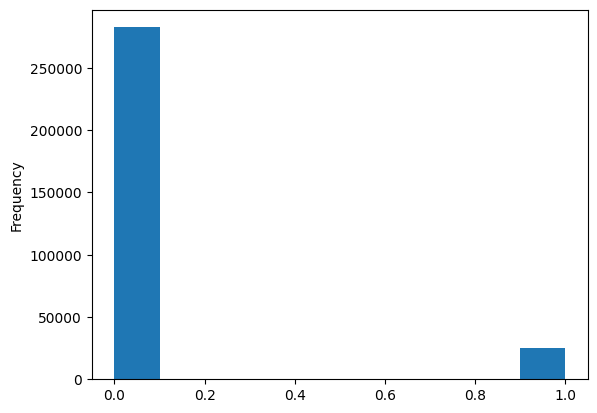

In [9]:
app_train['TARGET'].astype(int).plot.hist()

**Imbalanced class problem**: significantly more on-time repayments than defaults observed.

### Missing Values



In [11]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # List of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [13]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Keep all columns for now.

### Column types

In [137]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [138]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding Categorical Variables


One-hot encoding converts categorical values into binary vectors, and label encoding assigns each category a unique integer.

**Label encoding**: for any categorical variable with 2 unique categories.

**One-hot encoding**: for any categorical variable with more than 2 unique categories.

In [14]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [15]:
# One-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. This is a problem as there needs to be the same features in both training and testing datasets. The solution is to align the datasets.


In [16]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Way too many irrelevant features as a result of one-hot encoding, which we will leave for now. **Dimensionality reduction** to follow later in the notebook.

### Anomalies




In [142]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [17]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Seems to be an error. Max days employed is positive and over 1,000 years. Plot a histogram to visualize this.

Text(0.5, 0, 'Days Employment')

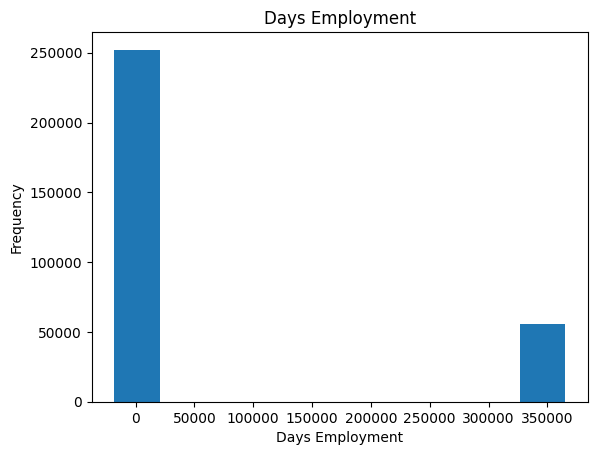

In [19]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment')
plt.xlabel('Days Employment')

Create a subset of the anomalies to compare their rates of default to the rest of the data.

In [22]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Non-anomalies default rate: %0.2f%%' % (100 * non_anom['TARGET'].mean()))
print('Anomalies default rate: %0.2f%%' % (100 * anom['TARGET'].mean()))
print('Number of anomalies: %d' % len(anom))

Non-anomalies default rate: 8.66%
Anomalies default rate: 5.40%
Number of anomalies: 55374


Anomalies have a significantly lower rate of default. All the anomalies have the same days employed of 365,243. Since the value is always the same, we want set them to the same value as they might all have something in common. Set all values to NaN, and add a column to indicate the values are anomalies for future reference.

Text(0.5, 0, 'Days Employment')

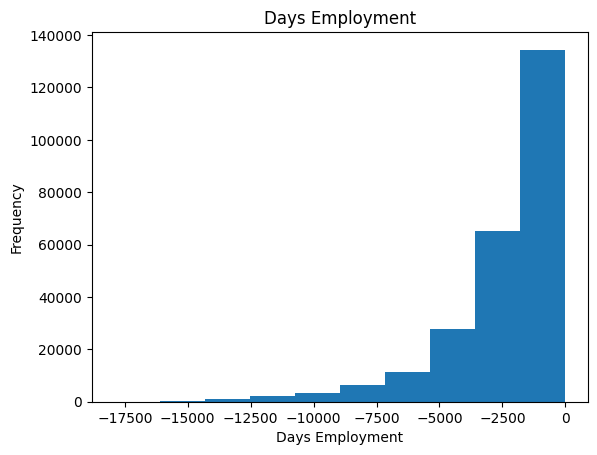

In [23]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment')
plt.xlabel('Days Employment')

Histogram seems much for aligned with reality. Must do the same thing for the testing dataset.

In [28]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Number of anomalies in the testing dataset: %d' % (app_test["DAYS_EMPLOYED_ANOM"].sum()))
print('Number of entries in the testing dataset: %d' % (len(app_test)))

Number of anomalies in the testing dataset: 0
Number of entries in the testing dataset: 48744


### Correlations

Calculate the Pearson correlation coefficient between every feature and the target variable to show potential relationships within the data.

In [32]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

#### Age

DAYS_BIRTH (i.e., the clients age in (negative) days at the time of the loan) has the hightest positive correlation with the target vaiable. Essentailly, the client is less likely to default the older they are. Use the absolute value to make DAYS_BIRTH more intuitive.

In [33]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

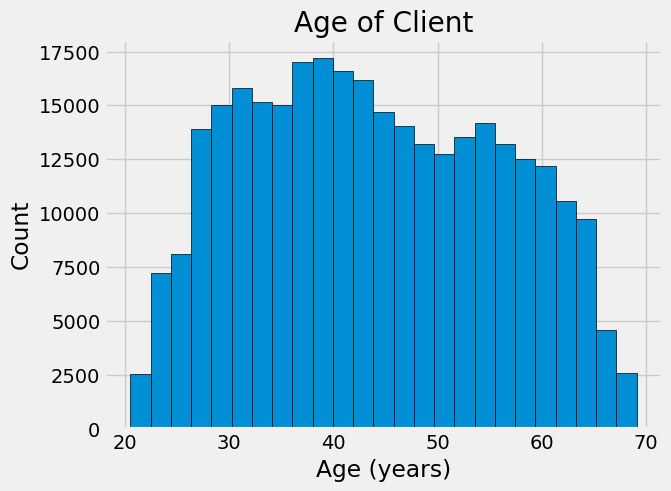

In [34]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

The histogram seems reasonable and has no outliers, but does not tell us much. Plot a KDE (Kernel Density Estimation) plot to visulaize the effect of the client age on the target variable. A KDE visualizes data distribution using a continuous probability density curve and smooths data points for clearer pattern insight.

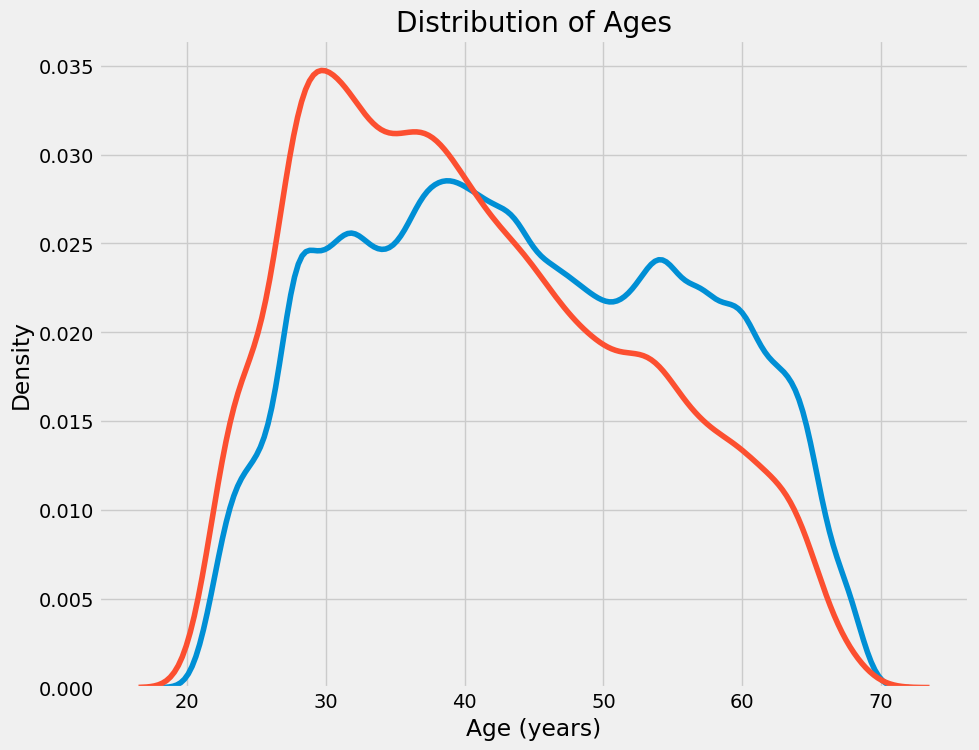

In [35]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The red curve (target = 1) is right skewed (towards the younger side). The two curves are skewed in opposite directions, which shows that the age variable does affect the target.

Exploring failure to repay loans by age brackets of five years.

In [37]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [38]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


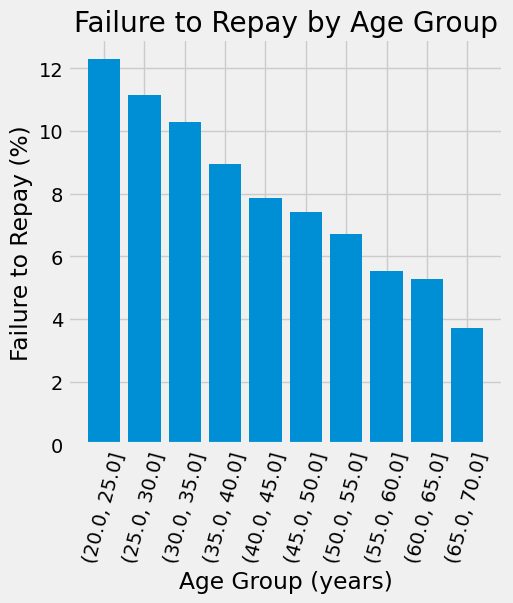

In [39]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

This plot shows that age has a significant impact on the clients ability to repay their loan.

#### Exterior Data Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. These features represent a "normalized score from external data source".

Explore the correlations of the EXT_SOURCE features with the target and with each other.

In [40]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

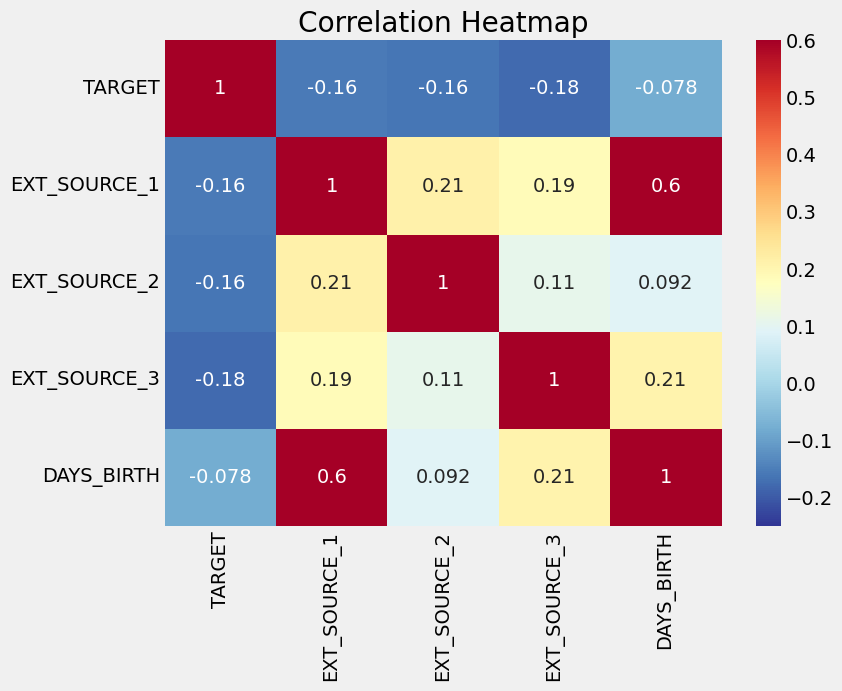

In [41]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

EXT_SOURCE features negatively correlate with the target, suggesting higher values increase loan repayment likelihood. DAYS_BIRTH positively correlates with EXT_SOURCE_1, hinting age as a factor in this score.

Explore feature distribution using KDE.

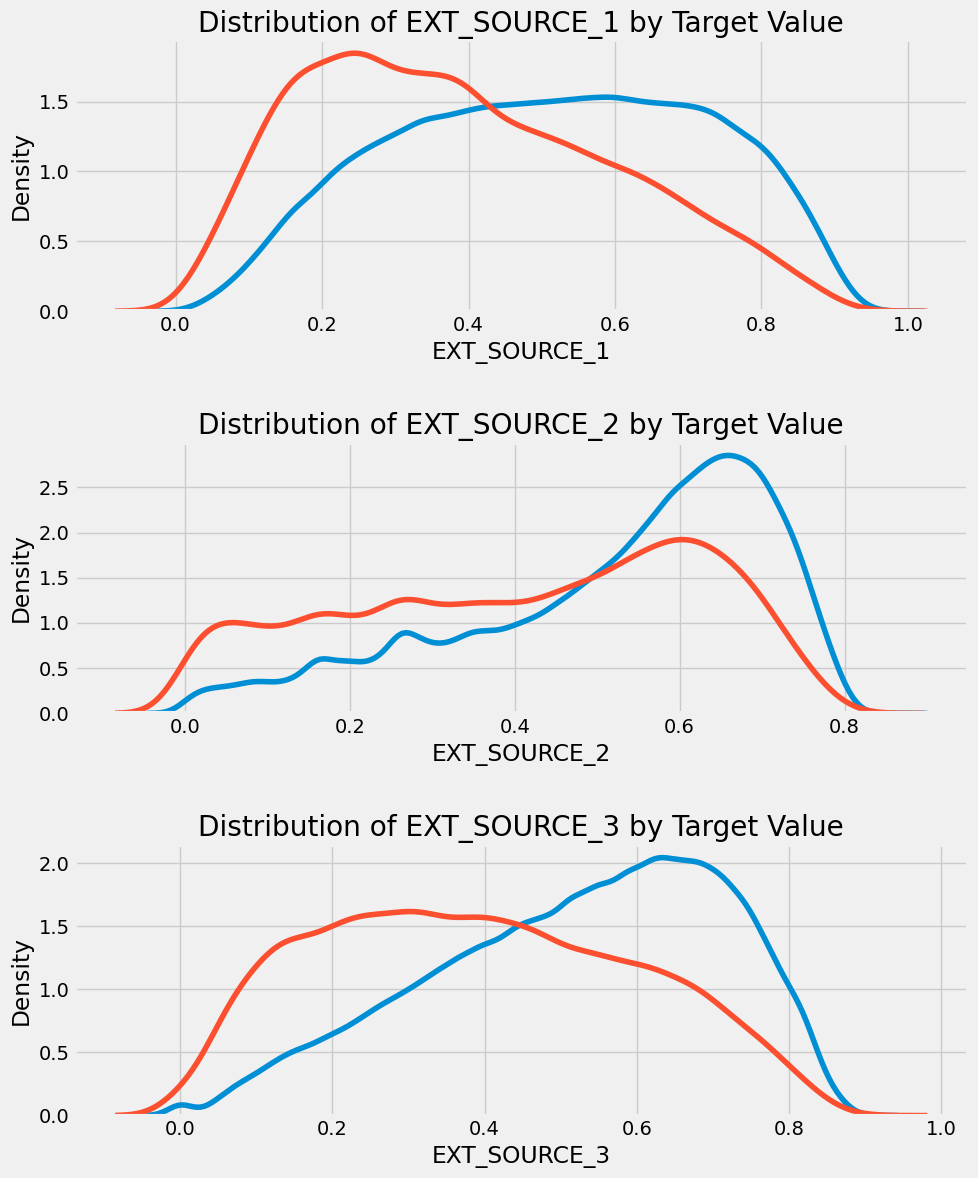

In [42]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


## Feature Engineering


### Polynomial Features

Derived attributes created by raising existing features to powers and multipling them together to create interaction terms, which reveal combined effects.

Create polynomial features using the features with the strongest correlation with the target variable, EXT_SOURCE and DAYS_BIRTH.

In [43]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [44]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Number of polynomial features generated: ', poly_features.shape)

Number of polynomial features generated:  (307511, 35)


In [45]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

See whether any of the 35 polynomial features are correlated with the target.

In [46]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Many of the new polynomial features have a far greater correlation with the target variable than the original features. We will save these features for future use and testing.

Add the polynomial features to a df.

In [47]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


### Domain Knowledge Features

Features created based on subject matter expertize.

The domain knowledge we are going to use to start out are inspired by other notebooks and limited credit model knowledge. They are:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income.
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income.
* `CREDIT_TERM`:  the length of the payment in months since the annuity is the monthly amount due.
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age.

Calculations below.

In [48]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [49]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

Plot the above features using a KDE plot, colored by target.


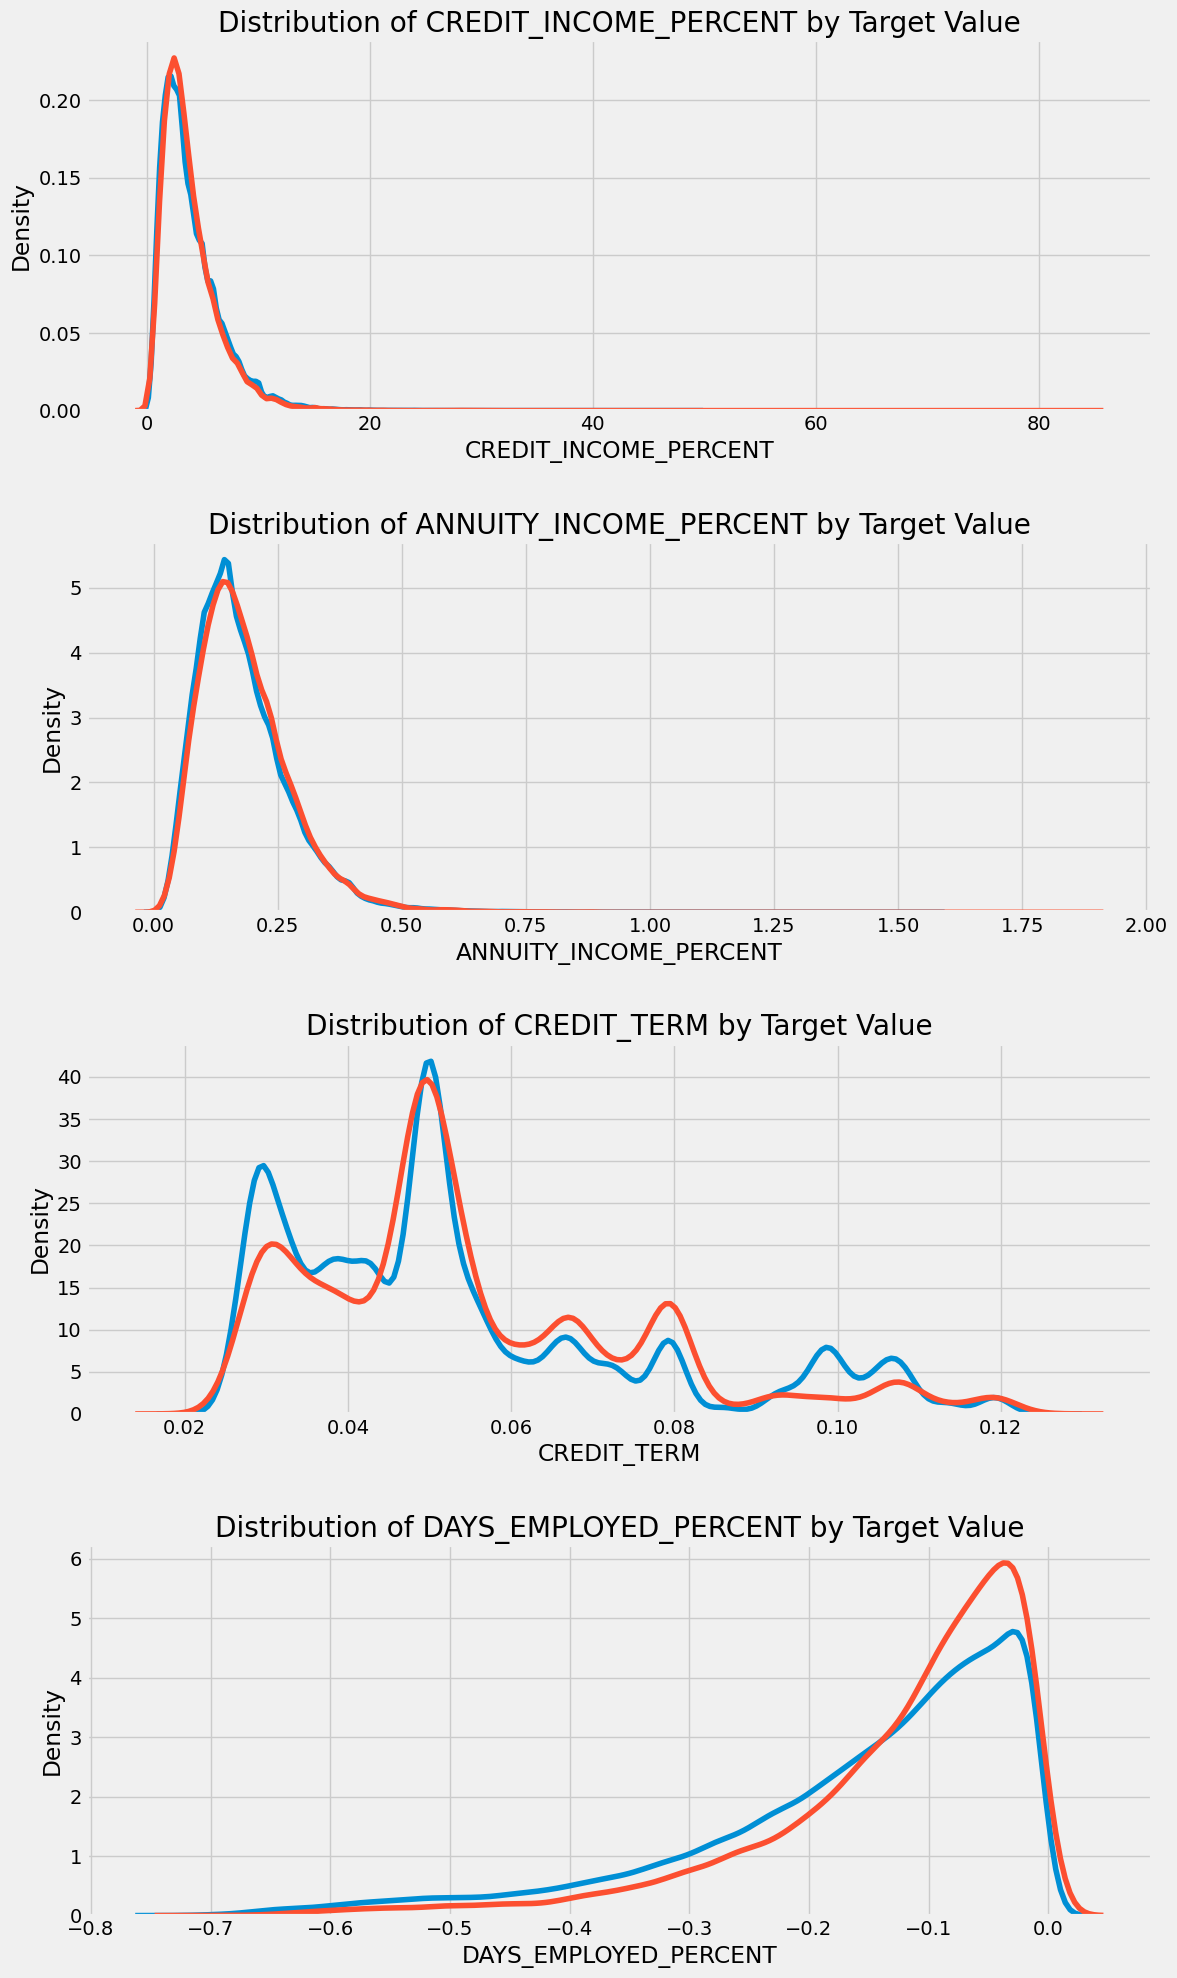

In [50]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

## Baseline Model: Logistic Regression

A naive baseline (guessing the same for all values) would result in a AUC ROC score of 0.5 on the test set.

Run the standard sklearn logistic regression model (with a lowered regularization parameter to reduce overfitting).

Use the encoded categorical variables only.

Imputation (to handle missing values) and normalizing the range of the features (scaling) using sklearn.

In [51]:
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [52]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

In [54]:
# Make predictions
# Make sure to select the second column only i.e. probability loan is not repaid
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [55]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


The above is the probability that the loan will NOT be repaid.

In [57]:
# Save the submission to a csv file
submit.to_csv('./output/log_reg_baseline.csv', index = False)


**AUC ROC score**: 0.6841

	SK_ID_CURR	TARGET
0	100001  	0.087750
1	100005  	0.163957
2	100013		0.110238
3	100028		0.076575
4	100038		0.154924

## Improved Model: Random Forest
 we can update the algorithm. using a Random Forest on the same training data to see how that affects performance

In [172]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [173]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [174]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/random_forest_baseline.csv', index = False)

### Make Predictions using Engineered Features



In [175]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [176]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [177]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

This model scored 0.678 
#### Testing Domain Features


In [178]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [179]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/random_forest_baseline_domain.csv', index = False)

This scores 0.679 when submitted

## Model Interpretation: Feature Importances


In [180]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

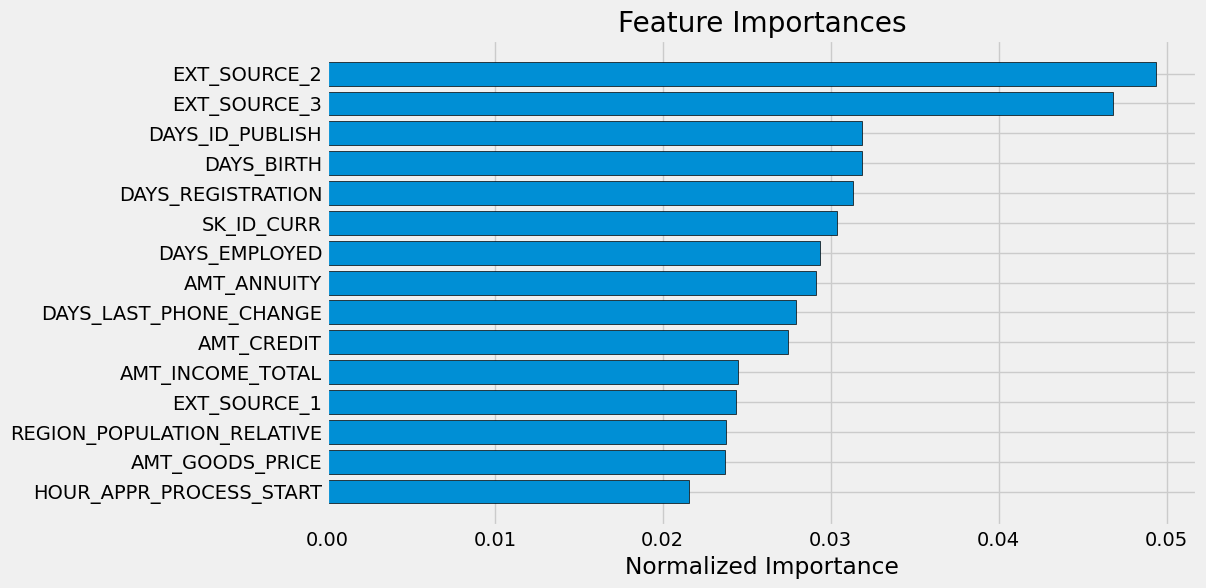

In [181]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

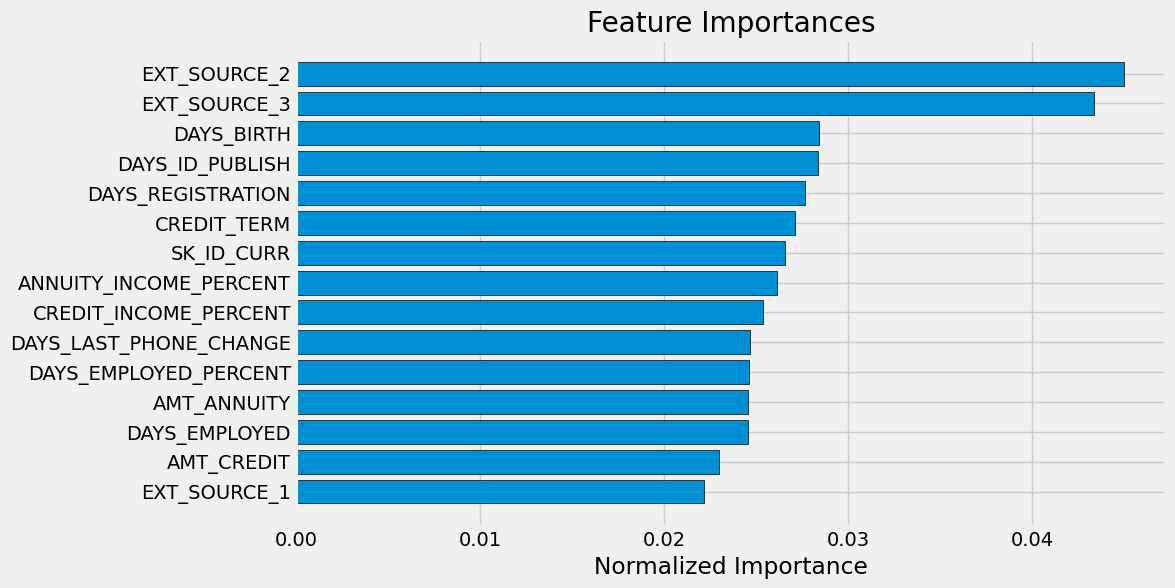

In [182]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

# Light Gradient Boosting Machine


In [183]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

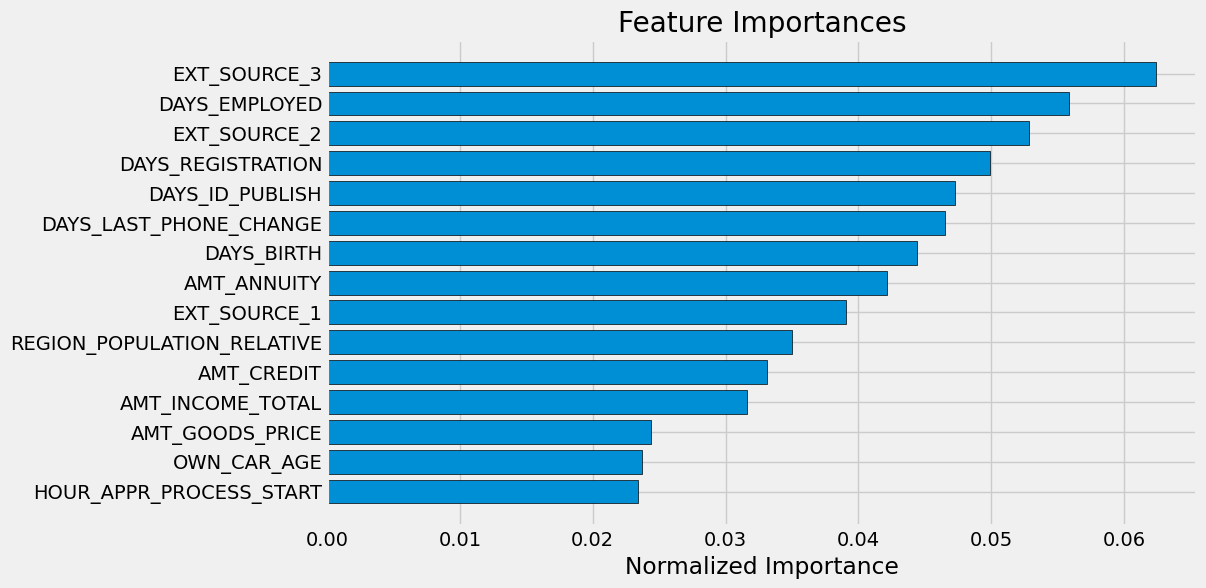

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard.

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12493
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19863, number of negative: 226146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12531
[LightGBM] [Info] Number of data po

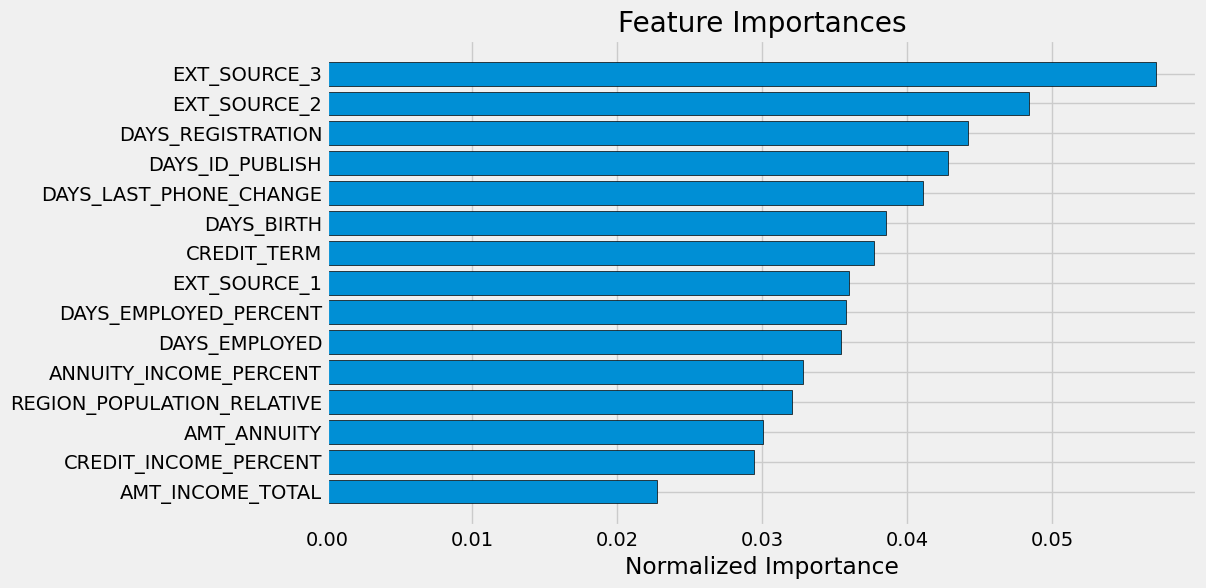

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

In [ ]:
submission_domain.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/baseline_lgb_domain_features.csv', index = False)

# Feature Engineering

# NOTEBOOK - 2: https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook

## Manual Feature Engineering with bureau_balance and bureau data

In [62]:
# Read in bureau
bureau = pd.read_csv('input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [63]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [65]:
# take the training data from the previous baseline
train = pd.read_csv('input/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


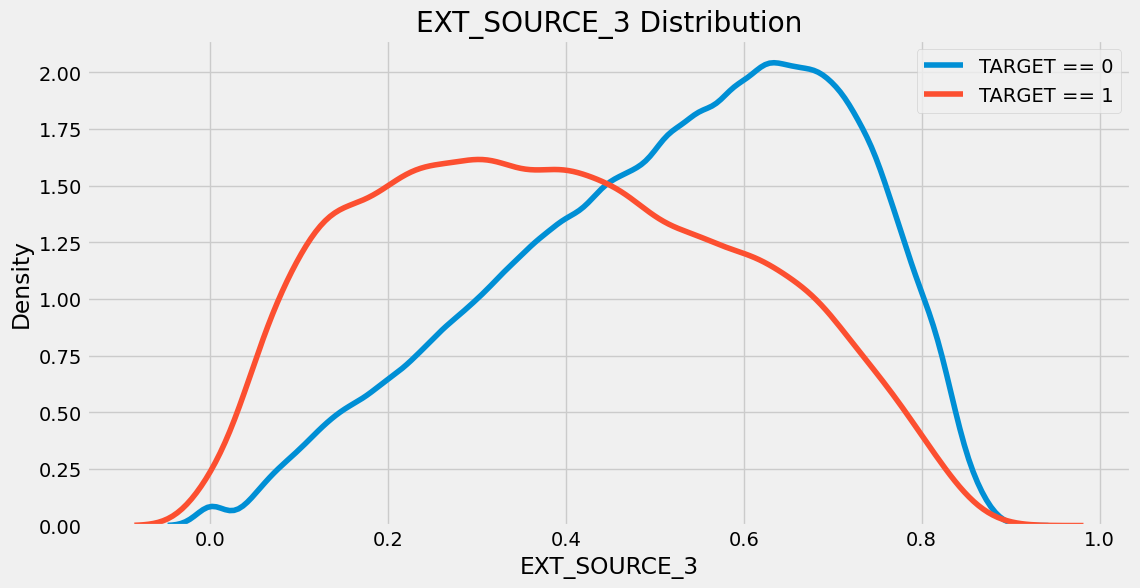

In [68]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


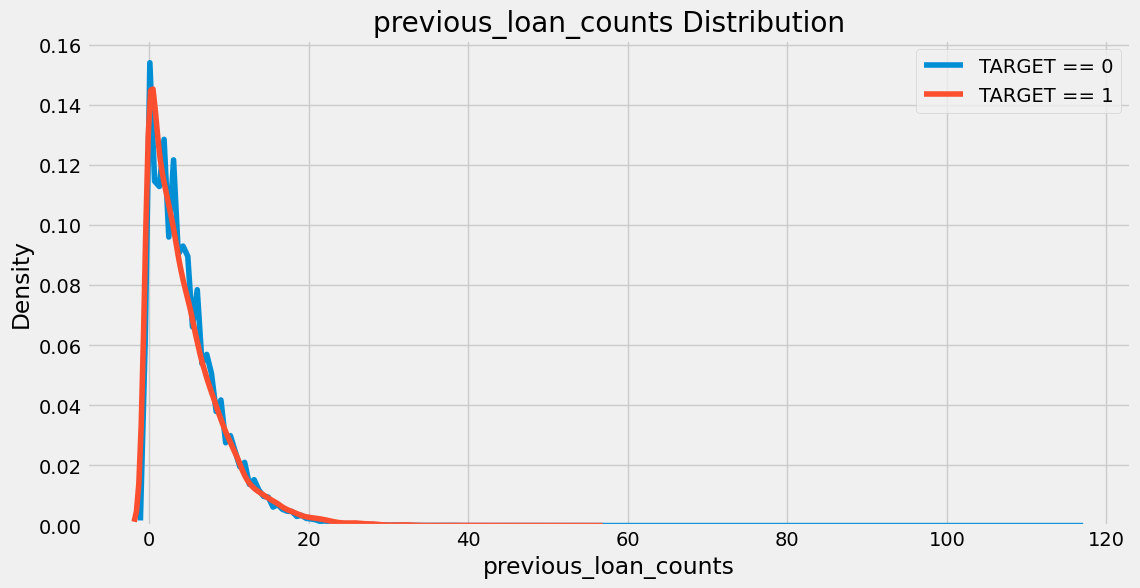

In [69]:
kde_target('previous_loan_counts', train)

In [71]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [76]:
# Identify numeric and non-numeric columns
numeric_cols = bureau.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = bureau.select_dtypes(exclude=[np.number]).columns.tolist()

non_numeric_cols

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [77]:
# Apply different aggregation for numeric and non-numeric columns
aggregations = {col: ['count', 'mean', 'max', 'min', 'sum'] for col in numeric_cols}
aggregations.update({col: ['count'] for col in non_numeric_cols if col != 'SK_ID_BUREAU'})

# Perform the groupby aggregation
bureau_agg = bureau.groupby('SK_ID_CURR').agg(aggregations).reset_index()

# # Flatten the multi-level column structure if needed
# bureau_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in bureau_agg.columns.values]

# View the first few rows
bureau_agg.head()

SK_ID_CURR                                         SK_ID_BUREAU  \
             count      mean     max     min     sum        count   
0     100001     7  100001.0  100001  100001  700007            7   
1     100002     8  100002.0  100002  100002  800016            8   
2     100003     4  100003.0  100003  100003  400012            4   
3     100004     2  100004.0  100004  100004  200008            2   
4     100005     3  100005.0  100005  100005  300015            3   

                                  ... DAYS_CREDIT_UPDATE       AMT_ANNUITY  \
          mean      max      min  ...                min   sum       count   
0  5896633.000  5896636  5896630  ...               -155  -652           7   
1  6153272.125  6158909  6113835  ...              -1185 -3999           7   
2  5885878.500  5885880  5885877  ...              -2131 -3264           0   
3  6829133.500  6829134  6829133  ...               -682 -1064           0   
4  6735201.000  6735202  6735200  ...               -121  -163           3   

                                      CREDIT_ACTIVE CREDIT_CURRENCY  \
          mean      max  min      sum         count           count   
0  3545.357143  10822.5  0.0  24817.5             7               7   
1     0.000000      0.0  0.0      0.0             8               8   
2          NaN      NaN  NaN      0.0             4               4   
3          NaN      NaN  NaN      0.0             2               2   
4  1420.500000   4261.5  0.0   4261.5             3               3   

  CREDIT_TYPE  
        count  
0           7  
1           8  
2           4  
3           2  
4           3  

[5 rows x 74 columns]

In [70]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

TypeError: agg function failed [how->mean,dtype->object]

PLEASE REFER The notebook 

In [78]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

PLEASE REFER notebook

In [80]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [ ]:
new_corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])

    # Append the list as a tuple

    new_corrs.append((col, corr))

In [ ]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

In [215]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.

    Parameters
    --------
        df (dataframe):
            the dataframe to calculate the statistics on
        group_var (string):
            the variable by which to group df
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated for
            all numeric columns. Each instance of the grouping variable will have
            the statistics (mean, min, max, sum; currently supported) calculated.
            The columns are also renamed to keep track of features created.

    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns

       # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    return agg

In [ ]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

In [ ]:
bureau_agg.head()

In [ ]:
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))

    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)

    return corrs

In [ ]:
# Categorical variables

categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

In [ ]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

In [ ]:
categorical_grouped.columns.levels[0][:10]

In [ ]:
categorical_grouped.columns.levels[1]

In [ ]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

In [ ]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

In [ ]:
train.shape

In [ ]:
train.iloc[:10, 123:]

In [201]:
def count_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical


In [ ]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
# Read in bureau balance
bureau_balance = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau_balance.csv')
bureau_balance.head()

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR`
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

In [ ]:
# Read in new copies of all the dataframes
train = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau_balance.csv')

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU','CREDIT_ACTIVE', 'CREDIT_CURRENCY','CREDIT_TYPE']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

In [ ]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

In [ ]:
missing_train = missing_values_table(train)
missing_train.head(10)

In [ ]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

In [ ]:
# Read in the test dataframe
test = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
print('Shape of Testing Data: ', test.shape)

In [ ]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [ ]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(10)

In [ ]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

In [ ]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

In [ ]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
train.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/train_bureau_raw.csv', index = False)
test.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_bureau_raw.csv', index = False)

In [ ]:
train.shape

In [ ]:
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [ ]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

In [ ]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

In [ ]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

In [ ]:
# Collinear Variables

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

In [ ]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

In [ ]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

In [ ]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

In [ ]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

In [ ]:
submission, fi, metrics = model(train_control, test_control)

In [ ]:
metrics

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/control.csv', index = False)

In [ ]:
submission_raw, fi_raw, metrics_raw = model(train, test)

In [ ]:
metrics_raw

In [ ]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [ ]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

In [ ]:
submission_raw.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_one.csv', index = False)

In [ ]:
# Test -2 Dropping highly cooreleated features
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

In [ ]:
metrics_corr

In [ ]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [ ]:
submission_corrs.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_two.csv', index = False)

# Some More Feature Engineering and PCA

# NOTEBOOK - 3: https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering-p2/notebook

### Data taken into account: 
    previous_application
    POS_CASH_balance
    installments_payments
    credit_card_balance

In [196]:
previous = pd.read_csv('Data/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 81)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
0,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
1,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
2,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
3,-815,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
4,-1072,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [202]:
train = pd.read_csv('Data/application_train.csv')
train = convert_types(train)
test = pd.read_csv('Data/application_test.csv')
test = convert_types(test)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

6363

In [203]:
# removing The missing values columns with more than 90% of data missing 
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


In [218]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [209]:
# Monthly Cash 

cash = pd.read_csv('Data/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()


Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [219]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum,SK_ID_CURR
0,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,32,36.0,36.000000,36.0,41,41,41,62.0,164.0,100001
1,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,361,456.0,456.000000,456.0,361,361,361,5415.0,8664.0,100002
2,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,256,248.0,283.000000,288.0,272,272,272,1608.0,2840.0,100003
3,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,12,12.0,15.000000,16.0,16,16,16,36.0,60.0,100004
4,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,99,99.0,128.699997,132.0,110,110,121,792.0,1287.0,100005


In [220]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 163)


0

PLEASE Refer Notebook

In [221]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [222]:
# Monthly Credit Data

credit = pd.read_csv('Data/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()


Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [223]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
0,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
2,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
3,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 377)


0

In [225]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [227]:
# Installment Payments

installments = pd.read_csv('Data/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [228]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,SK_ID_CURR,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,100001,1.528387e+05,1.528387e+05
1,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,100002,4.172888e+06,4.172888e+06
2,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,100003,1.134881e+07,1.134881e+07
3,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,100004,6.386539e+04,6.386539e+04
4,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,100005,5.054566e+05,5.054566e+05


In [229]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 107)


0

In [230]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [231]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1125)
Final Testing Shape:  (48744, 1124)


In [232]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

Final training size: 2.1
Final testing size: 0.33


In [ ]:
submission, fi, metrics = model(train, test)

In [ ]:
metrics

In [ ]:
submission.to_csv('submission_manualp2.csv', index = False)

# NOTEBOOK - 4 https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection/notebook

This notebook makes use of intermediate files can be found in the (input/) of the above link to notebook

In [236]:
# Read in the Data

train_bureau = pd.read_csv('Intermediate_Features/train_bureau_raw-2.csv', nrows = 1000)
test_bureau = pd.read_csv('Intermediate_Features/test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv('Intermediate_Features/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('Intermediate_Features/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [237]:
# Bureau only features 

bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 123 original features.
There are 179 bureau and bureau balance features.
There are 1043 previous Home Credit loan features.


In [238]:

# Combining data without creating duplicates

train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1345)
Testing shape:  (1000, 1344)


In [239]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1447)
Testing shape:  (1000, 1447)


In [240]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 49 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1398)
Testing shape:  (1000, 1398)


In [241]:
# Removing Correlated Features

# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [245]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [246]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 582 columns to remove.


In [247]:
# Drop correlated Variables

train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 816)
Testing shape:  (1000, 816)


In [248]:
train = pd.read_csv('Intermediate_Features/m_train_combined.csv')
test = pd.read_csv('Intermediate_Features/m_test_combined.csv')


print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 865)
Testing set full shape:  (48744, 864)


In [249]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()



# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_max    0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_min_min       0.773223
dtype: float64

In [250]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


In [251]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 845)
Testing set full shape:  (48744, 845)


In [252]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

### Feature Selection through feature importance

In [256]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
from sklearn.model_selection import train_test_split
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc')
    
    # Record the feature importances
    feature_importances += model.feature_importances_

In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

	feature	importance
24	EXT_SOURCE_1	167.5
25	EXT_SOURCE_2	141.5
26	EXT_SOURCE_3	136.0
368	client_installments_AMT_PAYMENT_min_sum	120.5
5	DAYS_BIRTH	98.5

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 271 features with 0.0 importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

PLEASE REFER Notebook

In [261]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 0)
Testing shape:  (48744, 0)


In [262]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [ ]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

In [ ]:
metrics

In [ ]:
submission.to_csv('selected_features_submission.csv', index = False)

In [ ]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

In [ ]:
metrics_small

In [ ]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

#### Dimentionality Reduction

##### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline

# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', Imputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

In [ ]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

In [ ]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target')

In [ ]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))



#### MLP

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split    

In [9]:
train_full = pd.read_csv('Data/train_full.csv')
test_full = pd.read_csv('Data/test_full.csv') 

In [6]:
X_train = train_full.drop('TARGET', axis=1)
y_train = train_full['TARGET']

In [35]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
from sklearn.impute import SimpleImputer

# Create an imputer with a chosen strategy (e.g., mean)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform it
X_train_split = imputer.fit_transform(X_train_split)

print(X_test_split.shape)
print(y_test_split.shape)

(49202, 537)
(49202,)


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)


In [53]:
X_train_tensor = torch.FloatTensor(X_train_resampled)
y_train_tensor = torch.FloatTensor(y_train_resampled).view(-1, 1)  # Reshape to (m, 1)

# Create a DataLoader for batching
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


input_size = X_train_split.shape[1]
hidden_size1 = 64
hidden_size2 = 32

model = MLPModel(input_size, hidden_size1, hidden_size2)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Now your model is trained! You can use it to make predictions on new data.


Epoch [1/10], Loss: 54.1667
Epoch [2/10], Loss: 45.8333
Epoch [3/10], Loss: 58.3333
Epoch [4/10], Loss: 54.1667
Epoch [5/10], Loss: 41.6667
Epoch [6/10], Loss: 41.6667
Epoch [7/10], Loss: 37.5000
Epoch [8/10], Loss: 66.6667
Epoch [9/10], Loss: 58.3333
Epoch [10/10], Loss: 50.0000


In [49]:
# count number of 1s and 0s in the test set

print(y_train_split.value_counts()/len(y_train_split)*100)  

TARGET
0    91.954514
1     8.045486
Name: count, dtype: float64


In [54]:
X_test_split = imputer.fit_transform(X_test_split)
X_test_split_tensor = torch.FloatTensor(X_test_split)
predictions = model(X_test_split_tensor)

In [17]:
X_train_split.drop(columns = ['Unnamed: 0'], inplace = True)

In [19]:
X_test_split.drop(columns = ['Unnamed: 0'], inplace = True)

In [58]:
log = {
    "Naive baseline": 0.5,
    "Logistic Regression": 0.6841,
    "Random Forest": 0.67796,
    "Random Forest with Domain Features": 0.68439,
    "lgb": 0.69971,
    "lgb w/Domain Features": 0.70948,
    "lgb w/noncollinear features": 0.74533,
    "lgb w/Buereau, Bureau balance and Application_Train": 0.7582,
    "lbg w/above data &non-collinear features": 0.75678,
    "lgb w/selected features": 0.78351,
    "Kaggle competition winner": 0.8057
    }

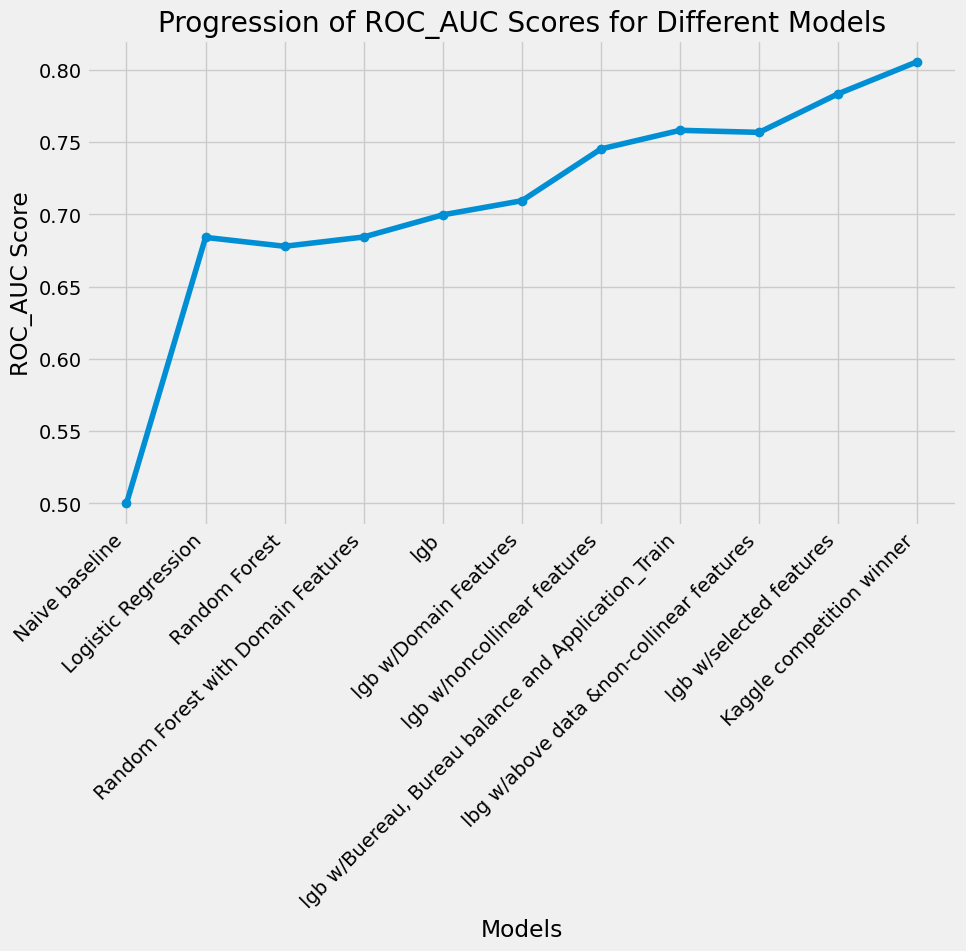

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(log.values(), marker='o', linestyle='-')

# Adding labels and title
plt.xticks(range(len(log)), list(log.keys()), rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('ROC_AUC Score')
plt.title('Progression of ROC_AUC Scores for Different Models')

# Display the plot
plt.show()

Kaggle Competition Summary: Home Credit Default Risk Prediction

Background:
The Kaggle competition, hosted by Home Credit, aimed to predict whether a client would repay a loan or face difficulties, leveraging a dataset with diverse sources. Home Credit, a service providing credit to the unbanked population, sought machine learning models to enhance their loan repayment prediction capabilities.

Data Overview:
The dataset comprised seven sources of information:

1. application_train/application_test: Main training and testing data, containing details about each loan application,      including the loan repayment status.
2. bureau: Information about clients' previous credits from other financial institutions, with each previous credit having its own row.
3. bureau_balance: Monthly data about the previous credits in the bureau, offering insights into the credit behavior over time.
4. previous_application: Details about previous applications for loans at Home Credit, providing additional context for clients with multiple loans.
5. POS_CASH_BALANCE: Monthly data about previous point-of-sale or cash loans, revealing transactional patterns.
6. credit_card_balance: Monthly data about previous credit cards, offering insights into credit card usage and balances.
7. installments_payment: Payment history for previous loans at Home Credit, including information about made and missed payments.



### Approach 1: Baseline Logistic Regression Model using application_train and application_test

1. Data Selection:

Focused solely on the application_train and application_test datasets, emphasizing simplicity in the initial approach.
2. Feature Engineering:

Calculated domain-specific features based on available information in the selected datasets.
Kept feature engineering straightforward to establish a baseline model.
3. Model Selection:

Chose Logistic Regression as the initial model due to its interpretability and efficiency, suitable for binary classification tasks.
4. Cross-Validation:

Implemented a 5-fold cross-validation strategy on the training set to assess model performance robustly.
Ensured that the model generalizes well to unseen data.
5. Training:

Trained the Logistic Regression model on each fold of the training data.


### Approach 2: Progressive Model Enhancement

1. Iterative Model Enhancement:

Transitioned to more sophisticated machine learning models after establishing the baseline with Logistic Regression.
* Random Forest: Introduced Random Forest, a decision tree ensemble, to capture complex non-linear relationships within the data.
Leveraged the strengths of ensemble methods for improved predictive performance.
* LightGBM: Further upgraded the model to LightGBM, a gradient boosting framework known for its efficiency and scalability.
Exploited LightGBM's ability to handle large datasets and deliver high predictive accuracy.

### Approach 3: Integration of External Data for Improved Model Performance

1. Initial Model using application Data Only:

Commenced the approach with a model built exclusively on the application data.
Achieved a baseline leaderboard score around 0.74, establishing a starting point for comparison.

2. Incorporation of External Data (Bureau and Bureau Balance):

Expanded feature set by integrating information from the bureau and bureau_balance datasets.
Recognized the need to leverage additional information for a more comprehensive understanding of clients' credit histories.

3. Manual Feature Engineering:

Engaged in manual feature engineering to extract meaningful insights from the newly integrated data.
Calculated domain-specific features that could enhance the model's ability to discriminate between loan repayment and default.

4. Exploration of Bureau and Bureau Balance Data:

Investigated patterns and trends within the bureau and bureau_balance datasets to identify relevant features.

### Approach 4: Comprehensive Data Integration for Score Improvement

1. Data Expansion:

Expanded the scope by including data from additional sources: previous_application, POS_CASH_balance, installments_payments, and credit_card_balance.
Recognized the potential value of diverse data in enhancing the model's predictive capabilities.

2. Feature Engineering and Integration:

Conducted thorough feature engineering on the newly incorporated datasets.
Extracted relevant information from previous_application, POS_CASH_balance, installments_payments, and credit_card_balance.

3. Cross-Data Relationships:

Explored relationships and dependencies between the different datasets.
Considered how insights from one dataset could complement or strengthen features derived from others.

4. Manual Feature Creation:

Applied domain knowledge to manually create features capturing important aspects of clients' credit histories.
Iteratively refined feature creation based on insights gained during exploration.


### Approach 5: Holistic Data Integration for Peak Model Performance

1. Comprehensive Data Joining:

Integrated data from all available sources, including bureau, bureau_balance, previous_application, POS_CASH_balance, installments_payments, and credit_card_balance.
Recognized the importance of a holistic dataset for capturing diverse aspects of clients' credit histories.
2. Feature Engineering and Calculation:

Conducted advanced feature engineering on the combined dataset.
Calculated and derived features leveraging the richness of information available across multiple sources.

3. Utilization of LightGBM Model:

Employed the LightGBM model consistently across all folds in the 5-fold cross-validation setup.
Leveraged LightGBM's efficiency and scalability for training on the comprehensive and large dataset.

4. Cross-Validation and Model Training:

Utilized cross-validation techniques to assess the model's performance consistently across different subsets of the dataset.
Ensured that the model maintains high predictive accuracy on various splits of the training data.

### Next Steps: Hyperparameter Optimization, Dimensionality Reduction, and Addressing Data Imbalance

1. Hyperparameter Optimization:

Objective: Fine-tune the model's hyperparameters for optimal performance.
Process:
Utilize techniques like grid search or random search to explore hyperparameter combinations.
Focus on parameters such as learning rate, tree depth, and subsample for LightGBM.
Employ cross-validation to evaluate the impact of different hyperparameter configurations on model performance.
Select the set of hyperparameters that maximizes the chosen evaluation metric (e.g., AUC_ROC).

2. Dimensionality Reduction:

Objective: Mitigate the curse of dimensionality, potentially improving model efficiency and reducing overfitting.
Process:
Consider techniques such as Principal Component Analysis (PCA) or feature selection algorithms.
Evaluate the impact of dimensionality reduction on model performance.
Balance the trade-off between retaining important information and reducing the number of features.
Monitor the model's ability to generalize on unseen data after dimensionality reduction.

3. Addressing Data Imbalance:

Objective: Enhance the model's ability to handle imbalanced classes, ensuring robust predictions for both repayment and default.
Process:
Explore techniques like oversampling the minority class (e.g., using Synthetic Minority Over-sampling Technique - SMOTE) or undersampling the majority class.
Experiment with class weights during model training to assign higher importance to the minority class.
Assess the impact of data imbalance mitigation techniques on model performance.
Validate the chosen approach with cross-validation to ensure consistent improvement across different folds.